# CMPT 2091 Final Project: Data Management and Analysis with Yelp API and Apache Spark

Group Members:
Mankaran Singh,
Ishmeet Singh,
Akshit Bhandari,

File Name should include all the names of your group members - FirstName_LastName_DBMS_Final_Project.ipynb

In [1]:
!pip install pyspark
!pip install findspark

### **Part One: Data Collection with Yelp API**


1.1 - Setup Yelp API
Before collecting data, you'll need to set up access to the Yelp API. Make sure you have your API key as outlined in the final project assignment document.

In [3]:
# Set up the Yelp API Key
api_key = '2xrdN0XvwNoiYGUf6UkoDYeEfFjfvDAOAnS1jzmo6WVGNvEeFmdYsme-LZurANfbOG9ijS08hU2ji_t4xElnxD9v2WpWp84UbVWVJ-1FyZcFMXyJSea8HCr6EQhRZ3Yx'  # Replace with your API key

# Yelp API endpoint for Business Search
endpoint_url = 'https://api.yelp.com/v3/businesses/search'

# Headers for authenticating the API request
headers = {
    'Authorization': f'Bearer {api_key}',
 }

1.2 - Making an API Request and Extracting Data
Use the Yelp API to fetch data based on your business idea. Adjust the parameters as necessary (location, categories, price range, etc.).

In [10]:
import requests
import pandas as pd

# Define the search parameters (customize based on your business idea)
params = {
    'term': 'restaurants',        # You can change the search term
    'limit': 50,                  # Max results per request
}

locations = ["San Jose", "Sunnyvale", "Santa Clara", "Mountain View", "Palo Alto"]

required_dataset = []

for location in locations:
    print(f"Fetching data for Location: {location}")
    params['location'] = location

    offset = 0
    while offset + params['limit'] <= 240:
        params['offset'] = offset
        print(f"Fetching data with offset {offset} for {location}")

        response = requests.get(endpoint_url, headers=headers, params=params)
        if response.status_code != 200:
            print(f"Error: {response.status_code}, {response.text}")
            break

        data = response.json()
        businesses = data.get("businesses", [])
        required_dataset.extend(businesses)

        if len(businesses) < params['limit']:
            print(f"Fetched all data for {location}. Stopping.")
            break

        offset += params['limit']

df_all_data = pd.DataFrame(required_dataset)
print("Data fetching complete.")
df_all_data.info()


Fetching data for Location: San Jose
Fetching data with offset 0 for San Jose
Fetching data with offset 50 for San Jose
Fetching data with offset 100 for San Jose
Fetching data with offset 150 for San Jose
Fetching data for Location: Sunnyvale
Fetching data with offset 0 for Sunnyvale
Fetching data with offset 50 for Sunnyvale
Fetching data with offset 100 for Sunnyvale
Fetching data with offset 150 for Sunnyvale
Fetching data for Location: Santa Clara
Fetching data with offset 0 for Santa Clara
Fetching data with offset 50 for Santa Clara
Fetching data with offset 100 for Santa Clara
Fetching data with offset 150 for Santa Clara
Fetching data for Location: Mountain View
Fetching data with offset 0 for Mountain View
Fetching data with offset 50 for Mountain View
Fetching data with offset 100 for Mountain View
Fetching data with offset 150 for Mountain View
Fetching data for Location: Palo Alto
Fetching data with offset 0 for Palo Alto
Fetching data with offset 50 for Palo Alto
Fetching

1.3 - Save Data to CSV
Once the data is collected, save it to a CSV file for future use.

In [13]:
# Save the extracted data into a CSV file
df_all_data.to_csv('yelp_restaurants_data.csv', index=False)
print(f"Finished collecting data. A total of {len(df_all_data)} records have been saved to yelp_restaurants_data.csv.")

Finished collecting data. A total of 1000 records have been saved to yelp_restaurants_data.csv.


In [15]:
from google.colab import files
files.download("yelp_restaurants_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**1.4 - Business Idea Explanation**

In this section, explain the business idea and why the data points (like business name, rating, price, etc.) are important for your application.

### Business Idea: Restaurant Recommendation System

Explain the purpose of your application and how the Yelp data you extracted will be used to support it. For example:

- **Business Idea**: The business idea is to build the working prototype of the Restaurant Recommendation System that would allow to find the optimal restaurants for travelers with regard to their preferences and location. Precisely this application allows for a quick decision since the users will be offered great restaurants to have a meal in.
- **Purpose of the Application:**: Using Yelp data, the system will determine the restaurants with the close proximity to the user’s preferences of ratings, price and categories. This makes it possible for clients to find and select restaurants in unknown territories.
- **Data Features Extracted**: Business name, ratings, price range, categories, and location.

These features are important because:
- **Business Name**
1. Aids in showing and giving an account of the restaurants in the recommendations.
2. Always gives travelers clear signs to identify or make judgment on what is available to them.
- **Ratings**
1. The performance of a particular business is essential in leveraging on ratings for filtering and recommendation.
2. They make sure the user receives only the restaurant with the best reviews.
- **Price**
1. Allows users to look for restaurants within a specific financial capability that a person has.
2. Factors into suggestions both more appropriate and reasonably priced.
- **Categories**
1. They assist segmentate group businesses based on cuisine type (Italian, vegan, Mexican, etc).
2. It enables people to either type in their preferred cuisine or choose one in order to get recommendations.
- **Location**
1. Separation of multiple coordinates by comma in a coordinate column along with latitude and longitude enables suggestions of restaurants nearby the user’s current location.
2. Helps those that are lost in look for dining areas they need in their regions of interest.
- **Distance**
1. Less commonly, it determines how close a restaurant is to the user.
2. Applied to sort recommendations regarding distance, so that people will find it easy to pay a visit.

**Example of the System in Action:**
A person visiting a new city urgently needs to choose an Italian restaurant with a high rating and an average check. The system will:

1. To highlight the Italian restaurants use the categories column.
2. Expand the opportunities for filtering using the Price option with reference to the cost offered by the service, corresponding to the user’s budget.
3. Order restaurants by the value that is in the rating column.
4. Click on the ‘distance’ column head to ensure that only related options nearer to the place of work come up on the screen.
5. Show the name of restaurant and its coordinate for the purpose of orientation.


# **Part Two: Data Management with Apache Spark**
**2.1- Setting Up PySpark**

Now that we have the Yelp data, we'll set up Apache Spark to handle large datasets.

In [17]:
# Importing necessary libraries for PySpark
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession

# Initialize the Spark session
spark = SparkSession.builder.appName('FinalProject').getOrCreate()

# Check if Spark session is initialized
spark


**2.2 - Loading Data into Spark DataFrame**

We'll load the data collected from Yelp into a Spark DataFrame.

In [18]:
# Load the Yelp CSV data into a Spark DataFrame
yelp_data = spark.read.csv('yelp_restaurants_data.csv', header=True, inferSchema=True)

# Display the schema and preview the data
yelp_data.printSchema()
yelp_data.show(5)


root
 |-- id: string (nullable = true)
 |-- alias: string (nullable = true)
 |-- name: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- is_closed: boolean (nullable = true)
 |-- url: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- categories: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- transactions: string (nullable = true)
 |-- price: string (nullable = true)
 |-- location: string (nullable = true)
 |-- phone: string (nullable = true)
 |-- display_phone: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- business_hours: string (nullable = true)
 |-- attributes: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+---------+--------------------+------------+--------------------+------+--------------------+--------------------+-----+--------------------+------------+--------------+----------------

In [19]:
yelp_data.createOrReplaceTempView("retsaurant")

**2.3 - Basic Operations on Data Using Spark DataFrame**

Here, you can perform basic transformations and operations, such as filtering, grouping, and aggregating.

*   Example: Filtering businesses with a rating greater than 4
high_rated_businesses = yelp_data.filter(yelp_data['rating'] > 4)
high_rated_businesses.show(5)
*   Example: Grouping by category and counting the number of businesses
category_counts = yelp_data.groupBy('categories').count()
category_counts.show()
*   Example: Aggregating by category to calculate the average rating
average_rating = yelp_data.groupBy('categories').agg({'rating_count': 'avg'})
average_rating.show()

In [27]:
# 1.
high_rated_restaurants = yelp_data.filter(yelp_data['rating'] > 4.5)
print("Restaurants with rating greater than 4.5:")
high_rated_restaurants.show(10)

# 2.
counting_categories = yelp_data.groupBy('categories').count()
print("Number of businesses per category:")
counting_categories.show(10)

# 3.
average_rating = yelp_data.groupBy('categories').agg({'rating': 'avg'})
print("Average rating by category:")
average_rating.show(10)

# 4.
price_range_counts = yelp_data.groupBy('price').count()
print("Number of businesses per price range:")
price_range_counts.show()

# 5.
most_common_category = yelp_data.groupBy('categories').count().orderBy('count', ascending=False).limit(1)
print("The most common business category:")
most_common_category.show()


Restaurants with rating greater than 4.5:
+--------------------+--------------------+--------------------+--------------------+---------+--------------------+------------+--------------------+------+--------------------+--------------------+-----+--------------------+------------+--------------+------------------+--------------------+--------------------+
|                  id|               alias|                name|           image_url|is_closed|                 url|review_count|          categories|rating|         coordinates|        transactions|price|            location|       phone| display_phone|          distance|      business_hours|          attributes|
+--------------------+--------------------+--------------------+--------------------+---------+--------------------+------------+--------------------+------+--------------------+--------------------+-----+--------------------+------------+--------------+------------------+--------------------+--------------------+
|berEiBE0f

### Part Three: Data Analysis Using Spark SQL
**3.1 - Register DataFrame as Temp View**

We need to register the Spark DataFrame as a temporary SQL view to run SQL queries.

In [28]:
# Register DataFrame as a temporary SQL view
yelp_data.createOrReplaceTempView("yelp_businesses")


**3.2 - Spark SQL Queries for Data Analysis**

Now, we can perform SQL queries to analyze the Yelp data. You need to perform an analysis of your data using Spark SQL and you should perform **a minimum of 10 SQL operations** to gain meaningful insights from the data you extraction from part one.

In [29]:
# Example SQL Query: Get top 5 businesses by rating
top_rated_businesses = spark.sql("""
SELECT name, rating, price, location
FROM yelp_businesses
WHERE rating > 4
ORDER BY rating DESC
LIMIT 5
""")
top_rated_businesses.show()

# Example SQL Query: Count the number of businesses by price range
price_range_counts = spark.sql("""
SELECT price, COUNT(*) as num_businesses
FROM yelp_businesses
GROUP BY price
""")
price_range_counts.show()

# Example SQL Query: Filter businesses with the '$' price range - indicating affordable businesses.
yelp_data_with_price_class = spark.sql("""
    SELECT *
    FROM yelp_businesses
    WHERE price IN ('$')
""")
yelp_data_with_price_class.show(5)


+--------------------+------+-----+--------------------+
|                name|rating|price|            location|
+--------------------+------+-----+--------------------+
|May Chieu Noodles...|   5.0| NULL|{'address1': '410...|
|Cosmic Cuisine Halal|   5.0| NULL|{'address1': '96 ...|
|Carlitos Tijuana ...|   5.0| NULL|{'address1': '265...|
|      Slanging Dough|   5.0| NULL|{'address1': '170...|
|  Medallo Restaurant|   5.0| NULL|{'address1': '186...|
+--------------------+------+-----+--------------------+

+-----+--------------+
|price|num_businesses|
+-----+--------------+
|   $$|           546|
|  $$$|           107|
| $$$$|            24|
| NULL|           307|
|    $|            16|
+-----+--------------+

+--------------------+--------------------+--------------------+--------------------+---------+--------------------+------------+--------------------+------+--------------------+------------+-----+--------------------+------------+--------------+------------------+-------------

In [33]:
# 10 SQL operations to gain meaningful insights from the data you extraction from part one.

# 1. Find the top-rated restaurants overall:
top_rated_restaurants = spark.sql("""
    SELECT name, rating, price
    FROM yelp_businesses
    ORDER BY rating DESC
    LIMIT 10
""")
top_rated_restaurants.show()

# 2. Count the number of restaurants by their open status:
open_status_counts = spark.sql("""
    SELECT is_closed, COUNT(*) as num_businesses
    FROM yelp_businesses
    GROUP BY is_closed
""")
open_status_counts.show()

# 3. Get restaurants with the highest review count:
highest_reviewed = spark.sql("""
    SELECT name, review_count, rating
    FROM yelp_businesses
    ORDER BY review_count DESC
    LIMIT 10
""")
highest_reviewed.show()

# 4. List restaurants with a specific category (e.g., Italian):
italian_restaurants = spark.sql("""
    SELECT name, rating, price
    FROM yelp_businesses
    WHERE categories LIKE '%Italian%'
    ORDER BY rating DESC
    LIMIT 5
""")
italian_restaurants.show()

# 5. Find restaurants within a specific price range (e.g., '$$'):
affordable_restaurants = spark.sql("""
    SELECT name, rating, review_count
    FROM yelp_businesses
    WHERE price = '$$'
    ORDER BY rating DESC
    LIMIT 10
""")
affordable_restaurants.show()

# 6. Get the average rating of all restaurants:
average_rating = spark.sql("""
    SELECT AVG(rating) as average_rating
    FROM yelp_businesses
""")
average_rating.show()

# 7. Count the number of restaurants in each category:
category_counts = spark.sql("""
    SELECT categories, COUNT(*) as num_businesses
    FROM yelp_businesses
    GROUP BY categories
""")
category_counts.show()

# 8. Find restaurants with a rating of 4 or higher and delivery options:
delivery_restaurants = spark.sql("""
    SELECT name, rating, categories
    FROM yelp_businesses
    WHERE rating >= 4 AND categories LIKE '%delivery%'
    ORDER BY rating DESC
""")
delivery_restaurants.show()

# 9. List restaurants that are currently open (not closed):
currently_open = spark.sql("""
    SELECT name, rating, price
    FROM yelp_businesses
    WHERE is_closed = FALSE
    ORDER BY rating DESC
    LIMIT 10
""")
currently_open.show()

# 10. Get the details of restaurants that have received the most recent reviews:
recent_reviews = spark.sql("""
    SELECT name, rating, review_count
    FROM yelp_businesses
    ORDER BY review_count DESC
    LIMIT 5
""")
recent_reviews.show()


+--------------------+------+-----+
|                name|rating|price|
+--------------------+------+-----+
|  Medallo Restaurant|   5.0| NULL|
|   Carnitas El Gordo|   5.0| NULL|
|         Agua Salada|   5.0| NULL|
|Silvas Brazilian ...|   5.0| NULL|
|Cosmic Cuisine Halal|   5.0| NULL|
|May Chieu Noodles...|   5.0| NULL|
|Tia Juanitas Mexi...|   5.0| NULL|
|Carlitos Tijuana ...|   5.0| NULL|
| Tono coffee project|   5.0| NULL|
|      Slanging Dough|   5.0| NULL|
+--------------------+------+-----+

+---------+--------------+
|is_closed|num_businesses|
+---------+--------------+
|    false|          1000|
+---------+--------------+

+--------------------+------------+------+
|                name|review_count|rating|
+--------------------+------------+------+
|            DishDash|        4706|   4.4|
|            DishDash|        4706|   4.4|
|            DishDash|        4706|   4.4|
|Orchard City Kitchen|        4643|   4.0|
|Orchard City Kitchen|        4643|   4.0|
|  The Breakfas

**3.3 - Data Visualization**

You can visualize the results of your Spark SQL analysis using libraries like Matplotlib or Seaborn.

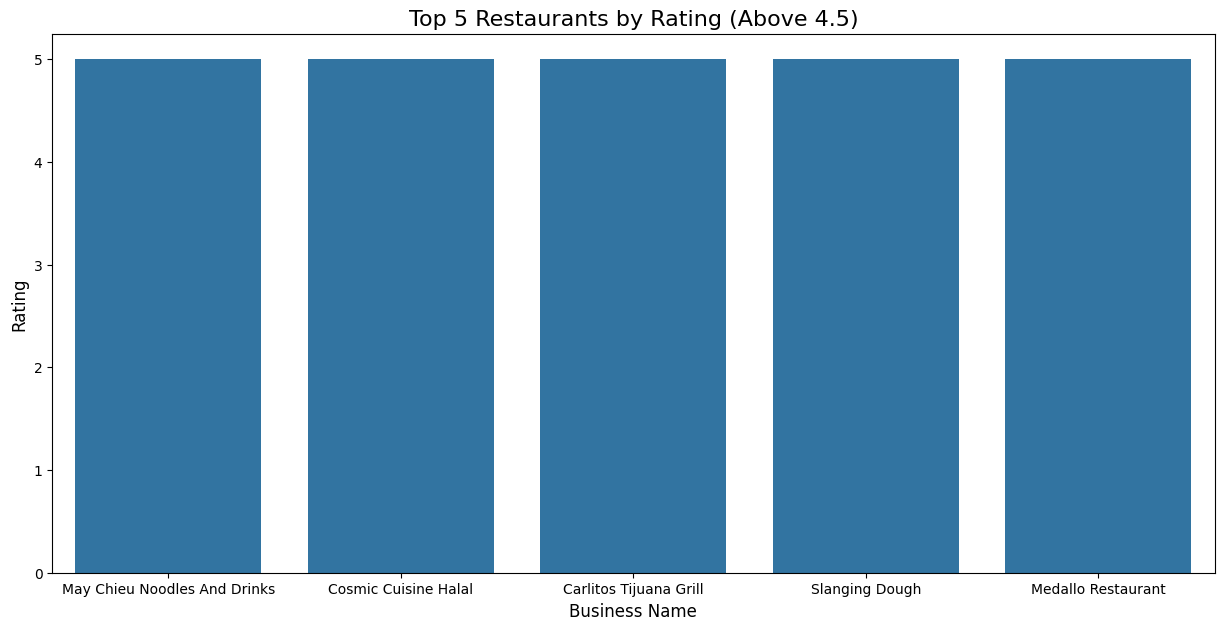

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Execute the SQL query to get top 5 rated businesses
top_rated_businesses = spark.sql("""
    SELECT name, rating, price, location
    FROM yelp_businesses
    WHERE rating > 4.5
    ORDER BY rating DESC
    LIMIT 5
""")

# Convert Spark DataFrame to Pandas DataFrame for visualization
top_rated_businesses_pandas = top_rated_businesses.toPandas()

# Plotting the number of businesses per category
plt.figure(figsize=(15,7))
sns.barplot(x='name', y='rating', data=top_rated_businesses_pandas)
plt.title('Top 5 Restaurants by Rating (Above 4.5)', fontsize=16)
plt.xlabel('Business Name', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()


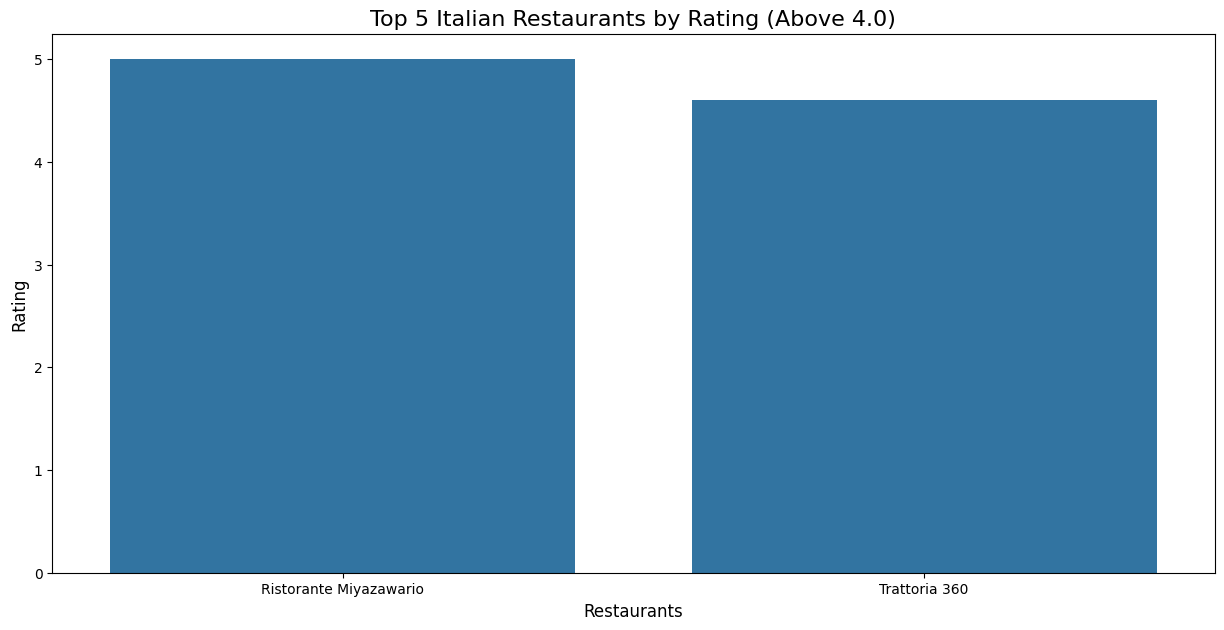

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Execute the SQL query to get top italian restaurants which has rating above than 4
top_italian_restaurants = spark.sql("""
    SELECT name, rating, review_count, price, location
    FROM yelp_businesses
    WHERE rating >= 4 AND categories LIKE '%Italian%'
    ORDER BY rating DESC
    LIMIT 5
""")

# Convert Spark DataFrame to Pandas DataFrame for visualization
top_italian_restaurants_pandas = top_italian_restaurants.toPandas()

# Plotting the number of businesses per category
plt.figure(figsize=(15,7))
sns.barplot(x='name', y='rating', data=top_italian_restaurants_pandas)
plt.title('Top 5 Italian Restaurants by Rating (Above 4.0)', fontsize=16)
plt.xlabel('Restaurants', fontsize=12)
plt.ylabel('Rating', fontsize=12)
plt.show()


<ipython-input-102-aee565e25188>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='distance', data=restaurants_pandas, palette='viridis')


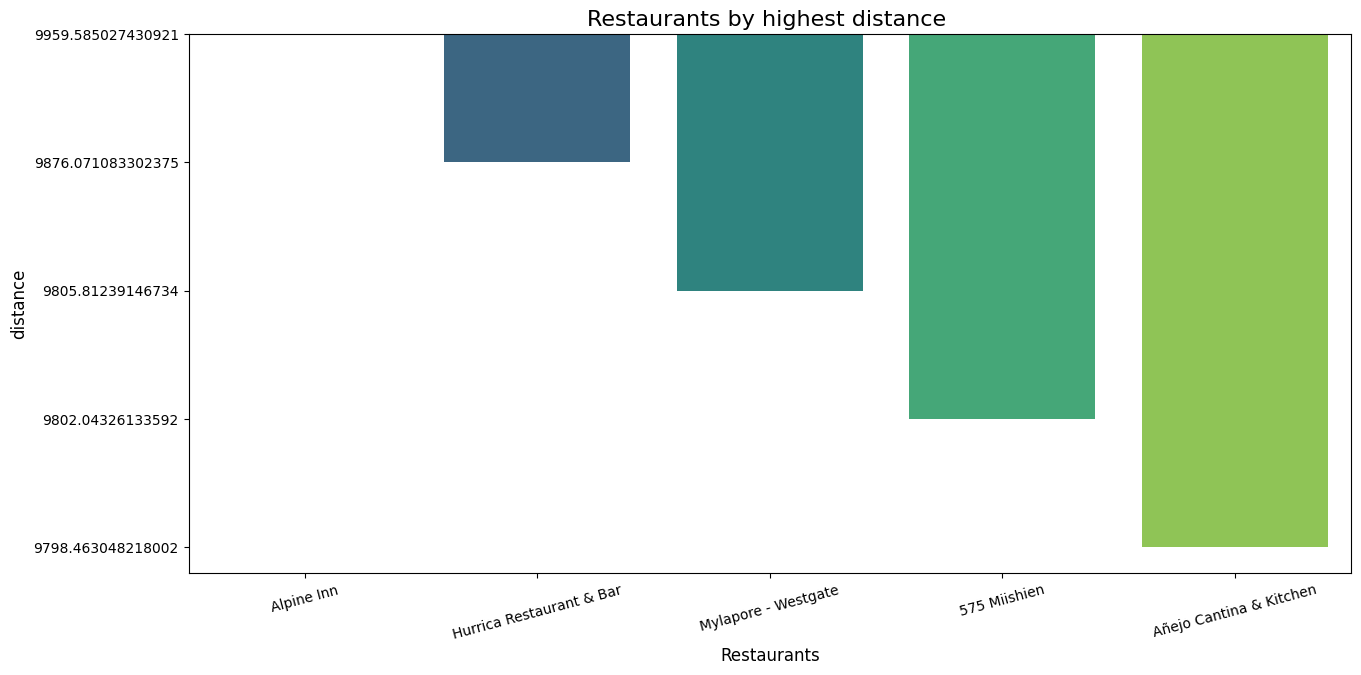

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Execute the SQL query to get the restaurants which has highest distance from the city
restaurants = spark.sql("""
    SELECT name, distance
    FROM yelp_businesses
    WHERE
    distance > 1000
    ORDER BY distance DESC
    LIMIT 5
""")

# Convert Spark DataFrame to Pandas DataFrame for visualization
restaurants_pandas = restaurants.toPandas()

# Plotting the number of businesses per category
plt.figure(figsize=(15, 7))
sns.barplot(x='name', y='distance', data=restaurants_pandas, palette='viridis')
plt.title('Restaurants by highest distance ', fontsize=16)
plt.xlabel('Restaurants', fontsize=12)
plt.ylabel('distance', fontsize=12)
plt.xticks(rotation=15)
plt.show()


Conclusion & Next Steps

### Conclusion
Summarize the key findings from your analysis, explaining how they support your business idea. For example:

- **Top Rated Businesses**: We built a many-to-many relationship between restaurants with a rating column, thereby guaranteeing the user gets results featuring highly rated and most credible restaurants. The above directly solves the user’s problem of getting quality recommendations.
- **Category Insights**: The data analysis of the categories column exposed the most requested kinds of restaurants, like Italian, Mexican, or Vegan, which allows giving more customized recommendations for the traveller and increases the range of available options for visitors.
- **Location and Distance**: From the two columns of coordinate and distance, the system is capable of suggesting to the user restaurants that exist in or around the user’s area of locoication. The new sort causes do improve the user experience due to the focus of distance from the user, in this case helping those who use applications in new cities.
- **Price Insights**: The price column makes it possible to filter according to the price so as to make recommendations inexpensive to the user but at the same time catering for the users budget and choice.

These results also prove the feasibility of the recommended system and show how the analyzed information can be used to generate a location-sensitive and individual eating experience.

### Future Steps
- **Expand Data Collection**: Combine further information about the number of research, working time, and customer feedback to expand the wealth of information and the variety of recommendations to clients.
- **Improve Recommendations**: As a recommendation model, it is vital to create a new product, with rating, categories, price, and distance as the basic attributes to meet the customer’s personalized needs and travel itineraries.
- **Interactive Map Features:** This is best incorporated in the coordinate column where there is a map view of restaurants; their positions are marked and distance highlighted to aid movement.
- **Improve User Filters:** Include filters for the possibility of choosing a restaurant by the type of cuisine for the needed nutrient value, the selected restaurant’s popularity among the users, and the working hours of the restaurant as to reflect the variants of user requirements.
- **Feedback and Optimization:** Users’ feedbacks should be collected based on the recommendations provided by the system in order to increase the possibility of its accurate outcome and satisfaction levels are to be enhanced in subsequent cycles.
For these issues, it is necessary to update the current trends registered in cuisines popularity rates and the preferences of users.

These next steps will make the recommendation system a complete travel guide for the diners and help them find restaurants that suit their taste and are located nearby.
